# Data Strikes (and Boycotts): Simulated Campaign Results

## Goals of this notebook
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. MovieLens 1M random boycotts
2. MovieLens 1M homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 20M random boycotts

It uses code from p_b_curve.py for plotting
It preloads constants from viz_constants (# users, # ratings, # hits). Can see how those are computed in ratings_hists notebook.


In [153]:
import viz_constants 
import importlib

# reload constants from file
# see https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
importlib.reload(viz_constants)
(
    num_users, num_ratings, num_hits
) = (
    viz_constants.num_users, viz_constants.num_ratings, viz_constants.num_hits
)
num_users, num_ratings, num_hits

({'ml-1m': 6040, 'ml-20m': 138493},
 {'ml-1m': 1000209, 'ml-20m': 20000263},
 {'ml-1m': 575281, 'ml-20m': 9995410})

In [154]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt

for dataset in ['ml-20m', 'ml-1m']:
    ratio = num_ratings[dataset] / num_users[dataset]
    print(dataset, 'ratio of ratings to users:', ratio)

ml-20m ratio of ratings to users: 144.4135299257002
ml-1m ratio of ratings to users: 165.5975165562914


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [155]:
df_1m = pd.read_csv('ml-1m_collected_10_28/all_results.csv', dtype={'indices': str})
df_1m['dataset'] = 'ml-1m'
assert len(df_1m) == len(df_1m[df_1m.ratingfrac.notna()])

In [156]:
df_20m = pd.read_csv('ml-20m_collected_11_01/all_results.csv', dtype={'indices': str})
df_20m['dataset'] = 'ml-20m'
assert len(df_20m) == len(df_20m[df_20m.ratingfrac.notna()])

Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^5

4. Computed surfaced hits and totalhits

Average # of surfaced hits for some group is equal to the totalhits for that group divided by the total # of possible hits averaged across folds

Because we use 5-fold validation, the total # of possible hits averaged across folds is total # of possible hits in the dataset divided by 5.

In [157]:
for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'GlobalMean')
    with open(filename_ratingcv_standards, 'r') as f:
        global_mean_res = json.load(f)
        
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'SVD')
    with open(filename_ratingcv_standards, 'r') as f:
        svd_res = json.load(f)
    
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -5) for x in df.num_ratings_missing]
    
    new_metric = 'surfaced-hits'

    groups = ['all', 'non-boycott', 'like-boycott']
    if dataset == 'ml-20m':
        groups = ['all', 'non-boycott'] # there are no like-boycotters in 20m
    for group in groups:
        # need to compute the total number of possible hits in our tests
        # can take the average number of hits for SVD
        #denom = (svd_res['hits'] / svd_res['normhits'] * num_users[dataset])
        denom = num_hits[dataset] / 5
        
        
        # Want to see the # hits per run, # users, and # ideal hits?
        print(svd_res['totalhits'], num_users[dataset], denom)

        # just divide totalhits by # ideal hits (total # hits / # folds) 
        for a in [
            '',
            'increase_',
            'standards_',
        ]:
            key = a + new_metric + '_' + group
            print(key)
            df[key] = [x / denom for x in df[a + 'totalhits_' + group]]

    # handle 'not-like-boycott' group
    other = 'totalhits'

    if dataset == 'ml-1m': # there is no not_like-boycott in 20m
        for x in [
            other,
            'standards_' + other,
            'increase_' + other,
            new_metric,
            'standards_' + new_metric,
            'increase_' + new_metric,
        ]:
            # the total hits of not-like-boycotters and like-boycotters add up to total hits of all non boycotters
            # the same is true for surfaced hits (surfaced hits is linearly proportional to total hits)
            df[x + '_not-like-boycott'] = df[x + '_non-boycott'] - df[x + '_like-boycott']

        df['percent_increase_' + other + '_not-like-boycott'] = 100 * (
            df['increase_' + other + '_not-like-boycott']
        ) / df['standards_' + other + '_not-like-boycott']

    for group in groups:
        df['percent_increase_' + new_metric + '_' + group] = 100 * (
            df['increase_' + new_metric + '_' + group]
        ) / df['standards_' + new_metric + '_' + group]

89045.6 6040 115056.2
surfaced-hits_all
increase_surfaced-hits_all
standards_surfaced-hits_all
89045.6 6040 115056.2
surfaced-hits_non-boycott
increase_surfaced-hits_non-boycott
standards_surfaced-hits_non-boycott
89045.6 6040 115056.2
surfaced-hits_like-boycott
increase_surfaced-hits_like-boycott
standards_surfaced-hits_like-boycott
1508048.2 138493 1999082.0
surfaced-hits_all
increase_surfaced-hits_all
standards_surfaced-hits_all
1508048.2 138493 1999082.0
surfaced-hits_non-boycott
increase_surfaced-hits_non-boycott
standards_surfaced-hits_non-boycott


# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [158]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    'ndcg5',
    'tailndcg10',
    'ndcgfull',
    'prec10t4',
    'rec10t4',
    'prec5t4',
    'rec5t4',
    'tailprec10t4',
    'tailrec10t4',
    #'prec5t4',
    #'tailprec5t4',
    'hits',
    'totalhits',
    'normhits',
]

organized_experiments = [
    'gender', 'state', 'power', 'genre', 'occupation', 'age'
]

# the algorithms we investigate (see old results for KNN experiments)
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
# the standards we compare against
standard_algo_names = [
    'SVD', 
    'GlobalMean', 
    #'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [159]:
dataset_to_algo_to_metric_to_altalgo = {}
ds2standards = {}

one_mill_svd = {}
for dataset in [
    'ml-1m',
    'ml-20m',
]:
    standard_results = {}
    algo2metric2altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'ml-1m':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = 0
                if metric == 'normhits':

                    denom = num_hits[dataset] / 5
                    #denom = (standard_results['SVD']['hits'] / standard_results['SVD']['normhits'] * num_users[dataset])
                    print(st_algo_name)
                    # since user isn't computed for 20m
                    
                    if st_algo_name in standard_results:
                        goodval = standard_results[st_algo_name].get('totalhits', 0) / denom
                        standard_results[st_algo_name]['surfaced-hits'] = goodval
                        
                        algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = algo2metric2altalgo[
                            main_algo_name]['totalhits'][
                            st_algo_name
                        ]
                        #algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
            if dataset == 'ml-20m':
                val = one_mill_svd.get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric]['1M_SVD'] = 0
            
            
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo2metric2altalgo
    ds2standards[dataset] = standard_results
# uncomment to examine
# pprint(dataset_to_algo_to_metric_to_altalgo)
# pprint(ds2standards)

SVD
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd
File not found: standard_results/ml-20m_ratingcv_standards_for_KNNBasic_user_msd.json
SVD
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd


In [160]:
ds2standards['ml-1m']['SVD']

{'avgest': 3.698830121286361,
 'avgest_frac': 1.0,
 'avgrating': 3.702850090758313,
 'avgrating_frac': 1.0,
 'falsepos': 4.310391862121126,
 'falsepos_frac': 1.0,
 'hits': 14.75632421589539,
 'hits_frac': 1.0,
 'mae': 0.68565924974011,
 'ndcg10': 0.7935157850853501,
 'ndcg10_frac': 0.7232870936361351,
 'ndcg5': 0.7859252131046933,
 'ndcg5_frac': 0.9259912768885006,
 'ndcgfull': 0.9097479696618601,
 'ndcgfull_frac': 1.0,
 'normhits': 0.7593777813214053,
 'normhits_frac': 0.9913166929463617,
 'prec10t4': 0.8044081587412997,
 'prec10t4_frac': 0.9913166929463617,
 'prec5t4': 0.8324186515278518,
 'prec5t4_frac': 0.9913166929463617,
 'rec10t4': 0.6396538707395909,
 'rec10t4_frac': 0.9913166929463617,
 'rec5t4': 0.4414764047881709,
 'rec5t4_frac': 0.9913166929463617,
 'rmse': 0.8734292086326507,
 'surfaced-hits': 0.7739313483323802,
 'tailavgest': 3.5576420697835696,
 'tailavgest_frac': 1.0,
 'tailavgrating': 3.5531289191178757,
 'tailavgrating_frac': 1.0,
 'tailfalsepos': 3.1776039014856456,

In [161]:
ds2standards['ml-1m']['SVD']['surfaced-hits'] - ds2standards['ml-1m']['MovieMean']['surfaced-hits']

0.014048786592986806

In [162]:
ds2standards['ml-20m']['SVD']['surfaced-hits'] - ds2standards['ml-20m']['MovieMean']['surfaced-hits']

0.03344635187551093

## Reported results: SVD standard surfaced-hits for ML-1M

In [163]:
round(ds2standards['ml-1m']['SVD']['surfaced-hits'] * 100, 1)

77.4

In [164]:
normalize_hits = False

for df, dataset in [
    (df_1m, 'ml-1m',),
    (df_20m, 'ml-20m',),
]:
    metric2altalgo = dataset_to_algo_to_metric_to_altalgo[dataset]['SVD']
    # will only work for SVD as its written right now.
    
    #personalization_boost_coefficient
    for pbc in [
        1.1, 1.02, 2, 4, 8,
    ]:
        for old_metric, k in [
            ('prec10t4', 10),
            #('ndcg10', 10),
            # the actual count of 4 star ratings in the whole ds
            ('hits', 1),
            ('totalhits', 1),
            ('normhits', 1)
        ]:
            for group in ['non-boycott', 'all']:
                # name the new dataframe column
                new_metric = '{}boosthits-{}'.format(pbc, old_metric)
                total_possible_hits = num_users[dataset] * k
                if old_metric == 'totalhits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric]
                elif old_metric == 'hits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric] * num_users[dataset]
                
                # boycotting users provide 0 hits. 
                # so with a full boycott, damage = total possible hits
                comparison = -1 * total_possible_hits
                #comparison = -1 * ds2standards[dataset]['SVD'][old_metric] * total_possible_hits

                key_template = 'percent_increase_{}_{}'
                new_key = key_template.format(new_metric, group)

   
                # no missing users in a strike ("All Users" perspective)
                if group == 'all':
                    frac_miss_arr = [0] * len(df.index)
                # there are missing users in a data boycott!
                else:
                    frac_miss_arr = list(df['num_users_boycotting'])

                labor_metric = 'labor-' + new_metric
                consumer_metric = 'consumer-' + new_metric

                # get the predicted diff if we switched to MovieMean
                pred_diff = metric2altalgo[old_metric]['MovieMean']
                # should get more negative as prec_val gets more negative
                #print(pred_diff)
                coefficients = np.polyfit(
                    [pred_diff, 0], # x values
                    [total_possible_hits/pbc - total_possible_hits, 0],# y values
                    1, # polynomial order, i.e. this is a line
                )

                df[key_template.format(labor_metric, group)] = [
                    ( coefficients[1] + coefficients[0] * prec_val  * (1 - frac_miss)) for (
                        prec_val, frac_miss
                    ) in zip(df[key_template.format(old_metric, group)], frac_miss_arr)
                ]
                df[key_template.format(consumer_metric, group)] = [
                    (comparison * frac_miss) for frac_miss in frac_miss_arr
                ]

                df[new_key] = [
                    (labor_power + consumer_power) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]
                df[new_key.replace('percent_increase_', '')] = [
                    (labor_power + consumer_power + ds2standards[dataset]['SVD']['totalhits']) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]

                if normalize_hits:
                    print('Normalizing. Will divide hit values by total possible hits.')
                    df[new_key] /= total_possible_hits
                    df[key_template.format(labor_metric, group)] /= total_possible_hits
                    df[key_template.format(consumer_metric, group)] /= total_possible_hits

                for st_al_nm in standard_algo_names:
                    old_val = metric2altalgo[old_metric][st_al_nm]
                    # convert from percent to raw precision change
                    old_val *= ds2standards[dataset]['SVD'][old_metric] / 100
                    # multiply by k and the probability of clicks b/c we want to get from prec@5 to hits
                    if not normalize_hits:
                        old_val *= total_possible_hits
                    metric2altalgo[new_metric][st_al_nm] = old_val
                    metric2altalgo[labor_metric][st_al_nm] = old_val
                    metric2altalgo[consumer_metric][st_al_nm] = old_val
            df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            df['increase_hit-ratio@{}_all'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            #print(df[['num_users_boycotting', 'increase_hits-prec5t4_non-boycott', 'increase_hits-prec5t4_all', 'increase_hit-ratio@5_non-boycott']])


## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts. We can also check that we have the # of samples and experiment indices that we expect.

# Reported Results: Number of Samples per strike/boycott group

In [165]:
samples_df_20m = df_20m[df_20m['type'] == 'sample_users']
print('\n===Heterogenous 20M Boycotts===\n')
print(samples_df_20m.name.value_counts())
print(samples_df_20m['indices'].value_counts())

samples_df_1m = df_1m[df_1m['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_1m.name.value_counts())
print(samples_df_1m['indices'].value_counts())

org_df = df_1m[df_1m['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())
print(org_df['indices'].value_counts())



===Heterogenous 20M Boycotts===

692 user sample       40
14 user sample        40
96945 user sample     40
138 user sample       40
27699 user sample     40
69246 user sample     40
83096 user sample     40
6925 user sample      40
13849 user sample     40
69 user sample        40
41548 user sample     40
124644 user sample    40
110794 user sample    40
55397 user sample     40
1385 user sample      40
137108 user sample    40
Name: name, dtype: int64
41-to-50    160
1-to-10     160
31-to-40    160
11-to-20    160
Name: indices, dtype: int64

===Heterogenous Boycotts===

3020 user sample    250
5980 user sample    250
60 user sample      250
3 user sample       250
1812 user sample    250
302 user sample     250
3624 user sample    250
30 user sample      250
4832 user sample    250
2416 user sample    250
5436 user sample    250
4228 user sample    250
604 user sample     250
6 user sample       250
1 user sample       250
1208 user sample    250
Name: name, dtype: int64
1-to-250  

### Bonus analysis: Compare Precision-Estimated Hits to Actual Hits

Here we look at what happens if we use precision to estimate # hits (based on  linear `precision ~ hits` model)


   num_users_boycotting    variable     value
0                   0.2  ndcg10_all  0.787265
1                   0.2  ndcg10_all  0.787250
2                   0.2  ndcg10_all  0.785957
3                   0.2  ndcg10_all  0.786934
4                   0.2  ndcg10_all  0.785387


C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


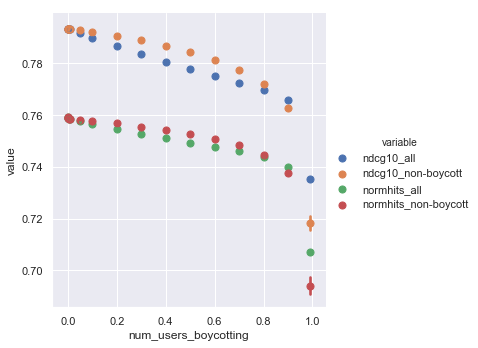

In [166]:
hits_df = samples_df_1m.copy()
hits_df = hits_df[~hits_df.hits_all.isna()]
hits_metric = 'ndcg10'
metric2 = 'normhits'
include = [
    'num_users_boycotting', 
]
hits_cols = [
    '{}_all'.format(hits_metric), 
    '{}_non-boycott'.format(hits_metric),
    #'{}_boycott'.format(hits_metric),
]
# for col in hits_cols:
#     hits_df[col] *= 0.76 / 14.75#num_users['ml-1m']

plot_metric2 = True
include += hits_cols
if plot_metric2:
    cols = [
        '{}_all'.format(metric2), 
        '{}_non-boycott'.format(metric2),
    ]

    include += cols
    
hits_df = hits_df[include].melt(id_vars='num_users_boycotting')
print(hits_df.head())

# for k in hits_df.num_users_boycotting:
#     print(k)
#     matches_from_hits = hits_df[hits_df.num_users_boycotting == k]
#     matches_from_orig = samples_df_1m[hits_df.num_users_boycotting == k]

sns.lmplot(
        x="num_users_boycotting", y="value", hue='variable', data=hits_df,
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
    )
plt.show()

In [167]:
from collections import defaultdict
name2vals = defaultdict(list)

for name, group in hits_df.groupby('num_users_boycotting'):
    #print(name)
    for subname, subgroup in group.groupby('variable'):
        #print(subname, subgroup['value'].mean())
        name2vals[subname].append(subgroup['value'].mean())
        
print(name2vals)

defaultdict(<class 'list'>, {'ndcg10_all': [0.7931250310896443, 0.7932713480025121, 0.7933384022023857, 0.7933118726742144, 0.7931513379318039, 0.7916711566486403, 0.7899893463109552, 0.7866861150073696, 0.7835196822674622, 0.7805176549803142, 0.7776396328406548, 0.7749214288544028, 0.7723996797486925, 0.7696992468304245, 0.7658600080020406, 0.7354183693266847], 'ndcg10_non-boycott': [0.7931275276641484, 0.7932797634204442, 0.7933561219656592, 0.7934163494733748, 0.793370163372054, 0.7927533890869488, 0.79205360787687, 0.7905728712441638, 0.7889011616093675, 0.7868481634529079, 0.7842452463726403, 0.7812693033980893, 0.7774655702733646, 0.7719522481723987, 0.7625499535674835, 0.7182904912395457], 'normhits_all': [0.7591481177386741, 0.7590574816292169, 0.7588924310552186, 0.7585775032894058, 0.758432497789692, 0.7575709076012412, 0.7565830980270858, 0.7547139516992252, 0.7527810822611931, 0.7510419907082321, 0.7493408319453282, 0.7476833966064055, 0.7460579473660366, 0.7439874267753422

### Do two metrics correlate?

In [168]:
from scipy.stats import pearsonr, spearmanr

try:
    for group in [
        'all', 'non-boycott',
    ]:
        x = '{}_{}'.format(hits_metric,group)
        y = '{}_{}'.format(metric2, group)
        print(x, y)
        print(pearsonr(name2vals[x], name2vals[y]))
#         plt.plot(name2vals[x], name2vals[y])
#     plt.show()
except Exception as err:
    print(err)
    pass

ndcg10_all normhits_all
(0.9842313247370235, 6.235479069629971e-12)
ndcg10_non-boycott normhits_non-boycott
(0.9949798764930259, 2.1262252636775034e-15)


## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots confusing.

In [169]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [259]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

template = 'Effect on {}, {}'

# Reported Results: Surfaced hits under 30% boycott and strike

In [171]:
df, ds = samples_df_1m, 'ml-1m'
print('Boycott:', round(df[(df.algo_name == 'SVD') & (df.name == '1812 user sample')]['surfaced-hits_non-boycott'].mean() * 100, 1))
print('Strike:', round(df[(df.algo_name == 'SVD') & (df.name == '1812 user sample')]['surfaced-hits_all'].mean() * 100, 1))

Boycott: 53.9
Strike: 76.7


# Reported Results: Figure 2, Left

ML-1m Surfaced Hits vs. Size

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.7668730516043459  |  ALL val:0.7668730516043459
ratio_nb: -0.42246146377096994  |  ratio_all:-0.42246146377096994
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7668730516043459}})


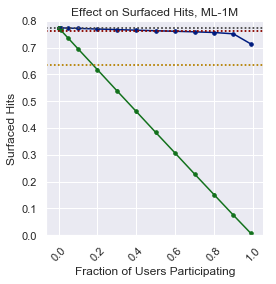

In [172]:
# Fig. 1, Upper Left
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'GlobalMean'],
    print_vals=[0.3],
    ylim=(0, 0.8),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported Results: Figure 2, right

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


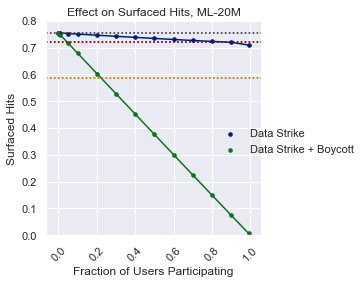

In [261]:
df, ds = samples_df_20m, 'ml-20m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=True, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'GlobalMean'], #line_names=['SVD', 'MovieMean', 'GlobalMean'],
    print_vals=False,
    ylim=(0, 0.8),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)
plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported results: Figure 3, left

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.7668730516043459  |  ALL val:0.7668730516043459
ratio_nb: -0.42246146377096994  |  ratio_all:-0.42246146377096994
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7668730516043459}})


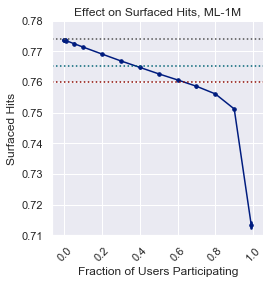

In [174]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="Surfaced Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    ylim=(0.71, 0.78),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.502413264043555  |  ALL val:-0.502413264043555
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.502413264043555}})


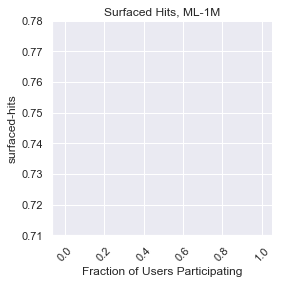

In [175]:
# ML-1M surfaced hits, normalized
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=True,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="surfaced-hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.71, 0.78),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported Results: Figure 3, Right

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.7419873722038416  |  ALL val:nan
ratio_nb: -0.1673525651453342  |  ratio_all:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.7419873722038416}})


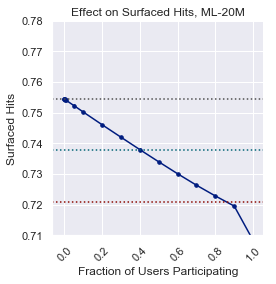

In [260]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
# Fig. 3
df, ds = samples_df_20m, 'ml-20m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="Surfaced Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    ylim=(0.71, 0.78),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.3702342137537009  |  ALL val:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.3702342137537009}})


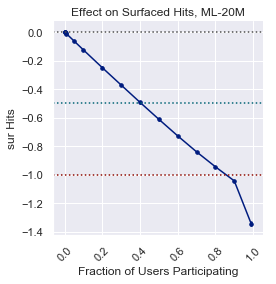

In [177]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_20m, 'ml-20m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=True,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="sur Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.695, 0.731),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

In [178]:
# Set colors for below "boost coefficient" plots

pinks = {}
pinks[2] = '#f8bbd0'
pinks[3] = '#f48fb1'
pinks[4] = '#f06292'
pinks[5] = '#ec407a'
pinks[6] = '#e91e63'
pinks[7] = '#d81b60'

purples = {}
purples[2] = '#e1bee7'
purples[3] = '#ce93d8'
purples[4] = '#ba68c8'
purples[5] = '#ab47bc'
purples[6] = '#9c27b0'
purples[7] = '#8e24aa'
#https://material.io/tools/color/#!/?view.left=0&view.right=0&primary.color=E1BEE7

## Look at how total hits changes under the "boost coefficient" model

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


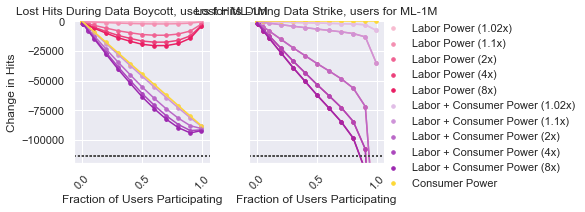

In [179]:
metric = 'totalhits'
_ = plot(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=3, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo['ml-1m'],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_totalhits.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


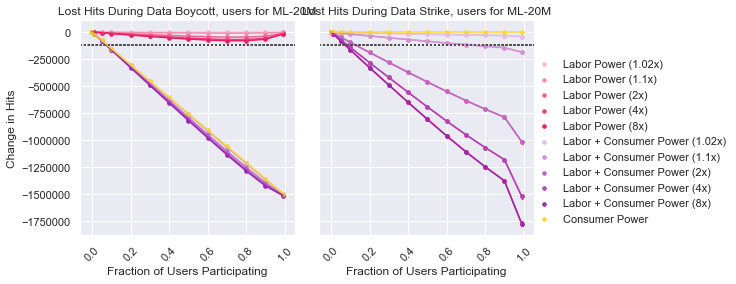

In [180]:
metric = 'totalhits'
df = samples_df_20m
ds = 'ml-20m'
_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], 
    #ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_complicatedhits.svg', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


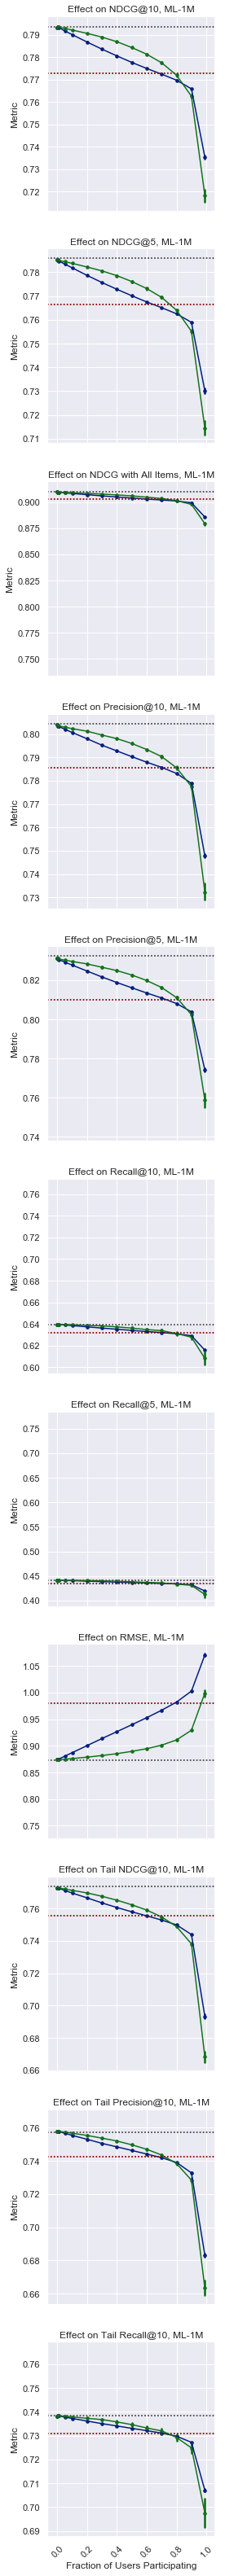

In [231]:
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'rmse',
        'ndcg10',
        'ndcg5',
        'tailndcg10',
        'ndcgfull',
        'prec10t4',
        'rec10t4',
        'prec5t4',
        'rec5t4',
        'tailprec10t4',
        'tailrec10t4',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Metric',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean',],
    print_vals=[],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_othermetrics.png', bbox_inches='tight', dpi=300)
plt.show()

### Find intersection of the non-boycott curve with horizontal lines

In [182]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

## Compute the 'algo_to_metric_to_group_to' for 1m in percent change

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.9120055342431352  |  ALL val:-0.9120055342431352
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-0.9120055342431352  |  ALL val:-0.9120055342431352
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.9120055342431352}})


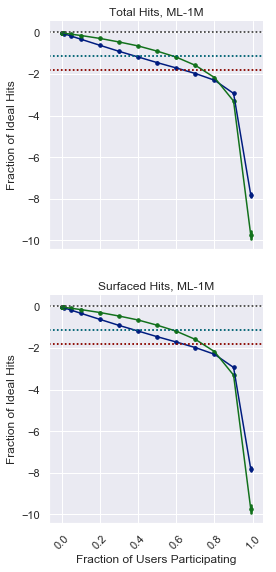

In [183]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 0


df, ds = samples_df_1m, 'ml-1m'

perinc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'surfaced-hits',
        'totalhits',
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.4855720701239015  |  ALL val:-0.4855720701239015
Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.502413264043555  |  ALL val:-0.502413264043555
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-0.5024132640435549  |  ALL val:-0.5024132640435549
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.4967995327370038}})


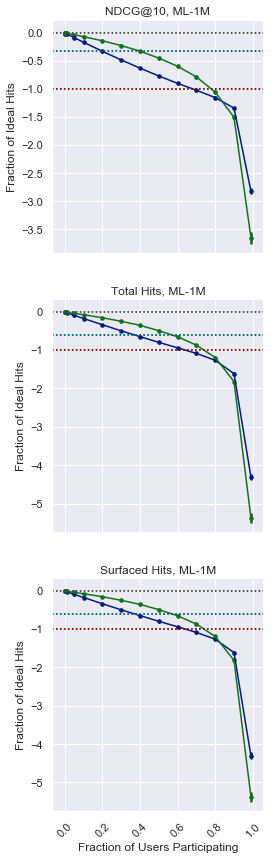

In [184]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 1


df, ds = samples_df_1m, 'ml-1m'

algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'ndcg10', 
        #'normhits',
        'surfaced-hits',
        #'ndcgfull',
        'totalhits'
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

In [185]:
metric = 'totalhits'
metric = 'surfaced-hits'
# comparisons = ds2standards['ml-1m']
# comparisons = {
#     key: comparisons[key].get(metric, 0) for key in comparisons.keys()
# }
comparisons = dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]
#movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean']
for group in [
    'all', 
    #'non-boycott'
]:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)):
        y = perinc_algo_to_metric_to_group_to['SVD'][metric][group]['interp_ratings'](x)
        #print(x,y)
        #print(comparisons['KNNBasic_item_msd'])

#         if not found_item:
#             if y <= comparisons['KNNBaseline_item_msd']:
#                 print(group + ' found item:')
#                 print(x / num_ratings['ml-1m'])
#                 found_item = True
#         if not found_user:
#             if y <= comparisons['KNNBasic_user_msd']:
#                 print(group + ' found user')
#                 print(x / num_ratings['ml-1m'])
#                 found_user = True
        if not found_itembasic:
            if y <= comparisons['KNNBasic_item_msd']:
                print(group + ' found knnbasicitem')
                print(x / num_ratings['ml-1m'])
                found_itembasic = True

all found knnbasicitem
0.37532155779442095


In [186]:
xvals = np.array(range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)))
arr = abs(perinc_algo_to_metric_to_group_to['SVD']['surfaced-hits']['all']['interp_ratings'](xvals) - comparisons['KNNBasic_item_msd'])
x = np.argmin(arr)
xvals[x]/1e6*100


37.53

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


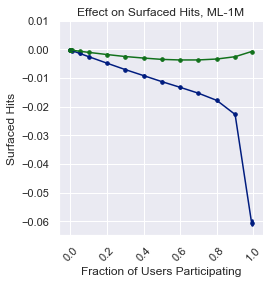

In [187]:
# temporarily placed here for comparison w/ following cell

df, ds = samples_df_1m, 'ml-1m'

inc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = [
        #'SVD', 'MovieMean', 'GlobalMean'
    ],
    print_vals=[],
    #ylim=(0, 0.8),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


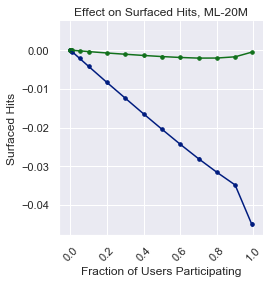

In [188]:
# temporarily placed here for comparison w/ following cell

df, ds = samples_df_20m, 'ml-20m'

twentyinc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = [
        #'SVD', 'MovieMean', 'GlobalMean'
    ],
    print_vals=[],
    #ylim=(0, 0.8),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Algo:SVD  |  Metric:ndcg10  |  #users:0.1
NB Val:-0.11747205591847873  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.2
NB Val:-0.23217072672126204  |  ALL val:nan
Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.34798496157665865  |  ALL val:nan
Algo:SVD  |  Metric:surfaced-hits  |  #users:0.1
NB Val:-0.1240902904489839  |  ALL val:nan
Algo:SVD  |  Metric:surfaced-hits  |  #users:0.2
NB Val:-0.24845016601357955  |  ALL val:nan
Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.3702342137537009  |  ALL val:nan
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.1: -0.12078117318373131, 0.2: -0.2403104463674208, 0.3: -0.35910958766517975}})


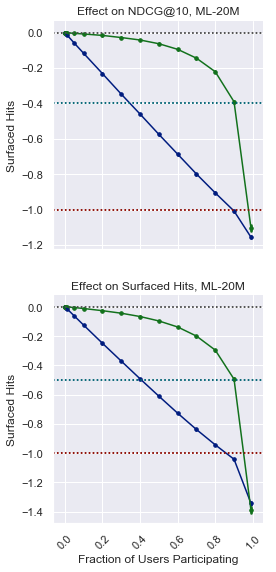

In [189]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 1

df, ds = samples_df_20m, 'ml-20m'

# save this data structure w/ interpolation
twenty_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'ndcg10', 
        'surfaced-hits',

    ],
    groups=[
        'all', 'non-boycott',
    ],
    legend=False, 
    ylabel="Surfaced Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd',
        'MovieMean'
    ],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_usernormhits.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported Results: Effects relative to non-personalized results
## First look at the relative change in surfaced hit for non-participants

In [256]:
# effects on non-participants, normalized 
d1= {}
group = 'non-boycott'
print(group)
d1['30percent_boycott_ml-1m'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 1)
d1['30percent_boycott_ml-20m'] = round(twenty_algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100, 1)
d1['30percent_boycott_ml-1m_ndcg10'] = round(algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 1)
d1['30percent_boycott_ml-20m_ndcg10'] = round(twenty_algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100, 1)

pprint(d1)

xvals = np.array(range(0, num_ratings['ml-20m'], int(num_ratings['ml-20m'] / 100)))
arr = abs(twenty_algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](xvals) - d1['30percent_boycott_ml-1m']/100)
x = np.argmin(arr)
print(xvals[x]/20e6*100, twenty_algo_to_metric_to_group_to['SVD']['surfaced-hits']['all']['interp_ratings'](xvals[x]))

non-boycott
{'30percent_boycott_ml-1m': -25.4, '30percent_boycott_ml-20m': -4.24}
77.00077 -0.9139693521035346


In [191]:
d2 = {}
group = 'all'
print(group)
d2['30percent_strike_ml-1m'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 1)
d2['37.5percent_strike_ml-1m'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.375 * num_ratings['ml-1m']) * 100, 1)

d2['30percent_strike_ml-20m'] = round(twenty_algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100, 1)
pprint(d2)

all
{'30percent_strike_ml-1m': -50.3,
 '30percent_strike_ml-20m': -37.0,
 '37.5percent_strike_ml-1m': -61.4}


## Let's look at the change in surfaced hits for the perspective of non-participants (marked "non-boycott")

In [257]:
d3 = {}
group = 'non-boycott'
d3['30_ml-1m'] = round(inc_algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 4)
d3['30_ml-20m'] = round(twentyinc_algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-20m']) * 100, 4)
d3['30_ml_all-20m'] = round(twentyinc_algo_to_metric_to_group_to['SVD']['surfaced-hits']['all']['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 4)

pprint(d3)

{'30_ml-1m': -0.2497, '30_ml-20m': -0.0995, '30_ml_all-20m': -0.0517}


# Targeted/Homogenous Boycotts (Results Part 2)

In [193]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [194]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [195]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [232]:

#metrics += ['hits-prec5t4', 'labor-hits-prec5t4', 'consumer-hits-prec5t4']

metrics = [
    #'surfaced-hits', 
    'totalhits'
]

# warning: you probably do not want to change these (unless you're sure)
NORMALIZE = 0
USE_PERCENTS = 1
USE_INCREASE = 1

copy_org_df = org_df.copy()
if NORMALIZE:
    for metric in metrics:
        for algo_name in algo_names:
            movie_val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
            for group in ['non-boycott', 'like-boycott', 'not-like-boycott']:
                col = 'percent_increase_{}_{}'.format(metric, group)

                copy_org_df.loc[
                    copy_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = '{}_expected'.format(metric)
    if USE_INCREASE:
        col = 'increase_' + col
    if USE_PERCENTS:
        col = 'percent_' + col
    for i, row in copy_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(perinc_algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    copy_org_df = copy_org_df.assign(**kwargs)

## LB = like-boycott
### So lbless is the number cases where the like boycott performance change was less than expected

In [233]:
from p_b_curve import select_cols, fill_in_longform
ylabel = 'ylabel'

def plot2(
        df, metrics, groups,
        increase=False, percents=False, kind='bar', height=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    Plots the results of homogenous boycotts
    e.g. 50% of Comedy fans boycott together
    """
    print('len of df (number of experiments included)', len(df.index))
    for name in list(set(df.name)):
#        tmp = df[df.name == name].num_ratings_missing.mean()
        tmp = df[df.name == name].num_users_boycotting.mean()
        print('Num users boycotting: {}. As a percent: {}'.format(tmp, tmp*100))
#         print('name', name)
#         print('mean number of ratings missing', tmp)pl
#         print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, increase=increase, percents=percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.factorplot(
        x=x, y=y, hue="group", data=longform,
        height=height, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(dict)
    ratios = defaultdict(dict)
    vals = defaultdict(dict)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = -1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        cols = {}
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                
                if 'expected' in col:
                    cols['expec'] = col
                if 'not-like' in col:
                    cols['not-like'] = col
                elif 'non-boycott' in col:
                    cols['nb'] = col
                elif 'like-boycott' in col:
                    cols['lb'] = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                arrs = {}
                print(cols)
                for key in cols:
                    arrs[key] = np.array(masked[masked.increase_type == cols[key]].value)
                
                means = {key: np.mean(arrs[key]) for key in arrs}
                print(means)
                
                ratio = means['nb'] / means['expec']
                diff = means['nb'] - means['expec']
                
                lb_diff = means['lb'] / np.mean(np.array(masked.num_users_boycotting))#- means['not-like']
                lb_ratio = means['lb'] / means['not-like']

                pval = stats.ttest_ind(arrs['expec'],arrs['nb'], equal_var=False).pvalue                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, cols['expec'], cols['nb']))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                print('LB to NB ratio: {}'.format(lb_ratio))
                print('lb_diff, mean_lb - mean_nl', lb_diff)
                print('pos = lb has more hits')
                name_to_ratios[name].append(ratio)
                diffs['nb'][name] = diff
                diffs['lb'][name] = lb_diff
                
                ratios['nb'][name] = ratio
                ratios['lb'][name] = lb_ratio
                
                vals['nb'][name] = means['nb']
                vals['lb'][name] = means['lb']
                vals['not-like'][name] = means['not-like']
                
                if pval < 0.5:
                    name_to_counts[name]['total_sig'] += 1

                if diff < 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                #print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']

    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Similar Users', 'Not Participating\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(ylabel)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)


In [234]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c', 'not-like-boycott': 'r'}

def plot_all_three_scenarios(df, height=6):

    total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), (diffs, ratios, vals) = plot2(
            half_users_df,
            metrics=metrics,
            increase=USE_INCREASE, percents=USE_PERCENTS,
            flip=True,
            groups=[
                'non-boycott', 'like-boycott', 
                'expected', 
                'not-like-boycott',
            ],
            height=height,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Half Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
    
    return (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)

In [235]:
copy_org_df = copy_org_df[copy_org_df.algo_name == 'SVD']

In [236]:
gender_boycotts = copy_org_df[copy_org_df['type'] == 'gender']
age_boycotts = copy_org_df[copy_org_df['type'] == 'age']
occupation_boycotts = copy_org_df[copy_org_df['type'] == 'occupation']
power_boycotts = copy_org_df[copy_org_df['type'] == 'power']
genre_boycotts = copy_org_df[copy_org_df['type'] == 'genre']

In [237]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
all_diffs = {
    'lb': {},
    'nb': {}
}
all_vals = {
    'lb': {},
    'nb': {},
    'not-like': {},
}
all_ratios = {
    'lb': {},
    'nb': {}
}

len of df (number of experiments included) 200
Num users boycotting: 0.3586092715231786. As a percent: 35.86092715231786
Num users boycotting: 0.007284768211920533. As a percent: 0.7284768211920533
Num users boycotting: 0.04999999999999998. As a percent: 4.999999999999998
Num users boycotting: 0.14139072847682124. As a percent: 14.139072847682124


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.7090938945436946, 'not-like': -0.6415628133505276}
'nb'
SVD totalhits
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.09669451216868094, 'not-like': -0.07880627835822933}
'nb'
SVD totalhits
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.7606702354077187, 'not-like': -0.4455063431857616}
'nb'
SVD totalhits
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.3785081505990596, 'not-like': -0.08929877792835414}
'nb'
SVD totalhits
Totals:
0 lbless, 0 sig, 0 less, and 0 more out of 0 total


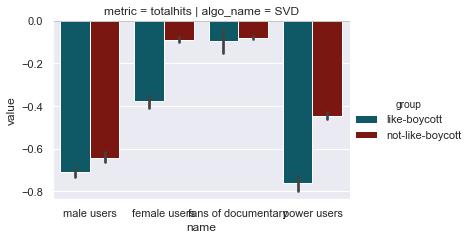

In [238]:
df1 = half_users(gender_boycotts)
df2 = half_users(genre_boycotts)
df3 = half_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        df2[(df2.name.str.contains('documentary')) & (df2.algo_name == 'SVD')],
        df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=metrics,
    increase=USE_INCREASE, percents=USE_PERCENTS,
    groups=[
        #'non-boycott', 
        'like-boycott', 
        #'expected',
        'not-like-boycott',
    ],
    height=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=False,
    palette=palette,
    aspect=1.5
)

plt.show()

## Male User and Female User Boycotts

len of df (number of experiments included) 100
Num users boycotting: 0.3586092715231786. As a percent: 35.86092715231786
Num users boycotting: 0.14139072847682124. As a percent: 14.139072847682124


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.7090938945436946, 'nb': -0.6819315076093885, 'not-like': -0.6415628133505276, 'expec': -0.6028904913540893}
totalhits SVD male users, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.131103438167972, pval: 9.79594079544206e-12
LB to NB ratio: 1.1052602797230244
lb_diff, mean_lb - mean_nl -1.9773440087922052
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.3785081505990596, 'nb': -0.13069019056499814, 'not-like': -0.08929877792835414, 'expec': -0.16268376048994793}
totalhits SVD female users, percent_increase_totalhits_expected, percent_increase_totalhits

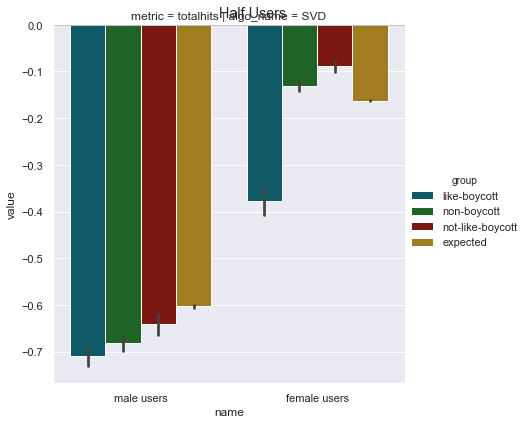

In [239]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])
    
print(all_vals)

plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

len of df (number of experiments included) 100
Num users boycotting: 0.04999999999999998. As a percent: 4.999999999999998
Num users boycotting: 0.051324503311258284. As a percent: 5.1324503311258285


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.7606702354077187, 'nb': -0.5064645666991994, 'not-like': -0.4455063431857616, 'expec': -0.27480547549140616}
totalhits SVD power users, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.8429929963860483, pval: 1.951646120513493e-31
LB to NB ratio: 1.7074285182299729
lb_diff, mean_lb - mean_nl -15.213404708154373
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': 0.07723871739637103, 'nb': -0.031542287284574776, 'not-like': -0.032478737969039516, 'expec': -0.034525881839211195}
totalhits SVD bottom 10% contributors, percent_increase_totalhits_expected, percent_

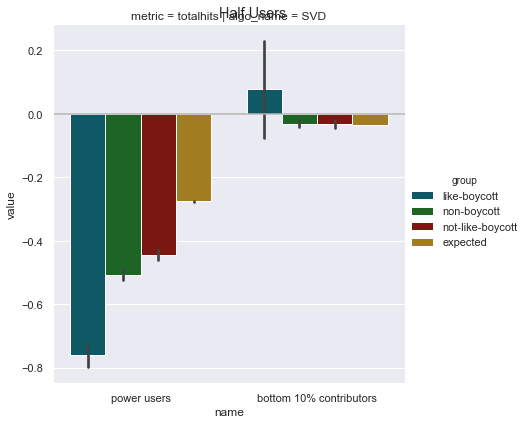

In [240]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(power_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])


plt.show()

# Age Boycotts

len of df (number of experiments included) 350
Num users boycotting: 0.09139072847682124. As a percent: 9.139072847682124
Num users boycotting: 0.17350993377483445. As a percent: 17.350993377483444
Num users boycotting: 0.04552980132450333. As a percent: 4.552980132450333
Num users boycotting: 0.041059602649006634. As a percent: 4.105960264900664
Num users boycotting: 0.03145695364238411. As a percent: 3.145695364238411
Num users boycotting: 0.0183774834437086. As a percent: 1.8377483443708602
Num users boycotting: 0.09867549668874175. As a percent: 9.867549668874174


C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.37875222766380806, 'nb': -0.14981290493905985, 'not-like': -0.12605829483136577, 'expec': -0.11773929763742316}
totalhits SVD 18-24, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.2724120828409136, pval: 2.7260791042391314e-07
LB to NB ratio: 3.004579969691666
lb_diff, mean_lb - mean_nl -4.1443178534228275
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.38471230191180583, 'nb': -0.3196678741358701, 'not-like': -0.29940680041373996, 'expec': -0.28769809177578054}
totalhits SVD 25-34, percent_increase_totalhits_expected, percent_increase_totalhits_non-b

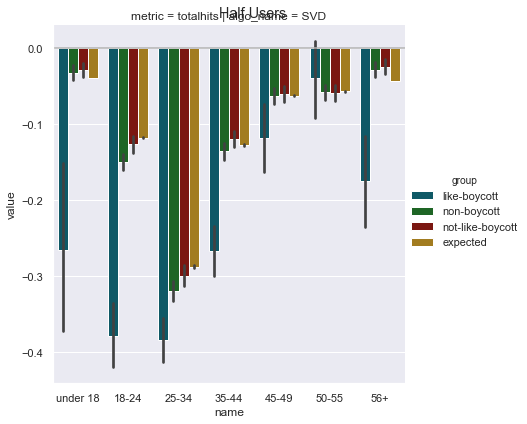

In [241]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])

plt.show()


# Occupation Boycotts

len of df (number of experiments included) 1050
Num users boycotting: 0.04370860927152315. As a percent: 4.3708609271523144
Num users boycotting: 0.0013245033112582788. As a percent: 0.13245033112582788
Num users boycotting: 0.02317880794701987. As a percent: 2.317880794701987
Num users boycotting: 0.016225165562913896. As a percent: 1.6225165562913895
Num users boycotting: 0.014238410596026487. As a percent: 1.4238410596026487
Num users boycotting: 0.03211920529801326. As a percent: 3.2119205298013256
Num users boycotting: 0.005794701986754968. As a percent: 0.5794701986754968
Num users boycotting: 0.02499999999999999. As a percent: 2.499999999999999
Num users boycotting: 0.01059602649006623. As a percent: 1.059602649006623
Num users boycotting: 0.009271523178807958. As a percent: 0.9271523178807959
Num users boycotting: 0.011754966887417218. As a percent: 1.1754966887417218
Num users boycotting: 0.05894039735099335. As a percent: 5.894039735099335
Num users boycotting: 0.041556291390

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.08101693656248753, 'nb': -0.0711520594019077, 'not-like': -0.07082717619162276, 'expec': -0.06284246490039284}
totalhits SVD academic/educator, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.1322289715192715, pval: 0.1660646337274261
LB to NB ratio: 1.1438679461580734
lb_diff, mean_lb - mean_nl -1.8535693062023655
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': 0.8301377950026823, 'nb': -0.03220081850578756, 'not-like': -0.03339253676578203, 'expec': -0.03061908351957516}
totalhits SVD farmer, percent_increase_totalhits_expected, percent_increase_totalhi

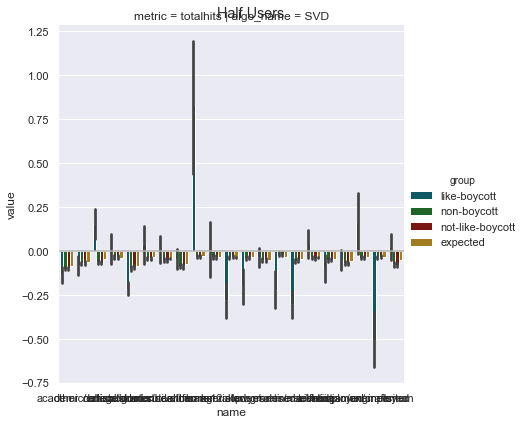

In [242]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(occupation_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])
plt.show()

# Genre Boycotts

len of df (number of experiments included) 900
Num users boycotting: 0.16953642384105969. As a percent: 16.95364238410597
Num users boycotting: 0.007284768211920533. As a percent: 0.7284768211920533
Num users boycotting: 0.06821192052980139. As a percent: 6.821192052980139
Num users boycotting: 0.02698675496688741. As a percent: 2.698675496688741
Num users boycotting: 0.0784768211920529. As a percent: 7.84768211920529
Num users boycotting: 0.05927152317880799. As a percent: 5.9271523178807985
Num users boycotting: 0.01589403973509932. As a percent: 1.5894039735099321
Num users boycotting: 0.031125827814569563. As a percent: 3.112582781456956
Num users boycotting: 0.09602649006622511. As a percent: 9.602649006622512
Num users boycotting: 0.08311258278145704. As a percent: 8.311258278145704
Num users boycotting: 0.011589403973509936. As a percent: 1.1589403973509935
Num users boycotting: 0.028145695364238422. As a percent: 2.8145695364238423
Num users boycotting: 0.05331125827814571. As 

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Nick\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.10694517119933454, 'nb': -0.17500970570835644, 'not-like': -0.19848348502279753, 'expec': -0.19365785353416737}
totalhits SVD fans of drama, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 0.9037056980365591, pval: 0.005269919825892276
LB to NB ratio: 0.5388114340447567
lb_diff, mean_lb - mean_nl -0.630809408246075
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.09669451216868094, 'nb': -0.07922714677851882, 'not-like': -0.07880627835822933, 'expec': -0.0453165024714638}
totalhits SVD fans of documentary, percent_increase_totalhits_expected, percent_incr

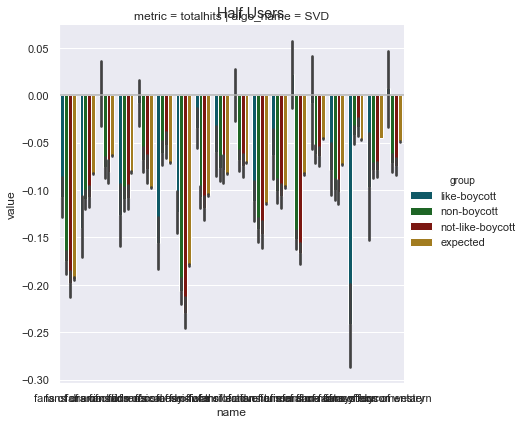

In [243]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(genre_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
    
for key in all_vals.keys():
    all_vals[key].update(vals[key])

plt.show()

# Reported Results: Total # of groups with overall effect less than expected

In [244]:
running_totals

{'total': 50,
 'total_lbless': 39,
 'total_less': 34,
 'total_more': 16,
 'total_sig': 37}

In [255]:
k_max = max(all_ratios['nb'], key=all_ratios['nb'].get)
print(k_max, all_ratios['nb'][k_max])

k_min = min(all_ratios['nb'], key=all_ratios['nb'].get)
print(k_min, all_ratios['nb'][k_min])

power users 1.8429929963860483
retired 0.5242004607723858


In [258]:
count = 0
for k, v in all_ratios['nb'].items():
    if v > 1:
        count += 1
count

34

In [247]:
from pprint import pprint
# pprint(all_diffs)
pprint(all_ratios)
# pprint(all_vals)

{'lb': {'18-24': 3.004579969691666,
        '25-34': 1.2849150432795284,
        '35-44': 2.237831339084171,
        '45-49': 1.9635283782496864,
        '50-55': 0.6769462474128377,
        '56+': 6.972284363448531,
        'academic/educator': 1.1438679461580734,
        'artist': -2.257956989076259,
        'bottom 10% contributors': -2.378131732519876,
        'clerical/admin': -0.36749036078092095,
        'college/grad student': 2.305404653154335,
        'customer service': -0.8960974925814327,
        'doctor/health care': -0.10177548342266234,
        'executive/managerial': 0.5297496923398696,
        'fans of action': 0.7623831892433915,
        'fans of adventure': 0.007202708846046949,
        'fans of animation': 1.311509702672208,
        "fans of children's": 0.007241274646600573,
        'fans of comedy': 0.10148062122461624,
        'fans of crime': 0.763151073242444,
        'fans of documentary': 1.2269899579464614,
        'fans of drama': 0.5388114340447567,
     

In [210]:
with open('all_ratios.json', 'w') as f:
    json.dump(all_ratios, f)
with open('all_diffs.json', 'w') as f:
    json.dump(all_diffs, f)
with open('all_vals.json', 'w') as f:
    json.dump(all_vals, f)

In [211]:
with open('some_distances.json', 'r') as f:
    group_to_group_to_vectype_to_distancetype_to_ = json.load(f)
    
row_dicts = []
for group, group_to_vectype_to_distancetype_to_ in group_to_group_to_vectype_to_distancetype_to_.items():
    if group == 'all':
        continue
    row_dict = {}
    row_dict['name'] = group
    for group2, vectype_to_distancetype_to_ in group_to_vectype_to_distancetype_to_.items():
        if group2 != 'all':
            continue
        for vectype, distancetype_to_ in vectype_to_distancetype_to_.items():
            for distancetype, val in distancetype_to_.items():
                row_dict['{}_{}'.format(vectype, distancetype)] = val
    row_dicts.append(row_dict)

df = pd.DataFrame(row_dicts)
df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(df.name)
]

In [212]:
with open('all_ratios.json', 'r') as f:
    all_ratios = json.load(f)
    
with open('all_diffs.json', 'r') as f:
    all_diffs = json.load(f)
    
with open('all_vals.json', 'r') as f:
    all_vals = json.load(f)
    
with open('group_to_num_ratings', 'r') as f:
    group_to_num_ratings = json.load(f)
temp_df = pd.DataFrame.from_dict(group_to_num_ratings, orient='index')
temp_df.index = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .replace('Top 10% contributors', 'power users')
    .strip()
    .lower()
    for x in list(temp_df.index)
]
print(temp_df)
group_to_num_ratings = temp_df.to_dict()[0]


#print(group_to_num_ratings)    
lb_ratios = all_ratios['lb']
nb_ratios = all_ratios['nb']



row_dicts = []
for key, val in lb_ratios.items():
    row_dict = {
        'name': key,
        'like-boycott-ratio': val,
        'non-boycott-ratio': nb_ratios[key],
        'like-boycott-diff': all_diffs['lb'][key],
        'non-boycott-diff': all_diffs['lb'][key],
        'num_ratings': group_to_num_ratings[key],
        'like-boycott-val': all_vals['lb'][key],
        'not-like-val': all_vals['not-like'][key],
    }
    row_dicts.append(row_dict)
ratios_df = pd.DataFrame(row_dicts)

df = df.merge(right=ratios_df, on='name', how='inner')
print(df.head())

                               0
male users                753769
female users              246440
fans of drama             283280
fans of animation         123314
fans of children's         85744
fans of musical           120386
fans of comedy            150470
fans of sci-fi            101277
fans of war               268388
fans of thriller          164050
fans of action            124499
fans of adventure         102718
fans of crime             177567
fans of romance           149309
fans of film-noir         126151
fans of fantasy            45766
fans of mystery           106949
fans of horror             48464
fans of documentary        43364
fans of western            52250
under 18                   27211
18-24                     183536
25-34                     395556
35-44                     199003
45-49                      83633
50-55                      72490
56+                        38780
other                     130499
academic/educator          85351
artist    

In [213]:
names = {
    'name': 'Name', 'num_ratings': '# Ratings', 
    'like-boycott-ratio': 'Similar User Effect Ratio',
    'like-boycott-val':  '% change surfaced hits, similar users',
    'not-like-val':  '% change surfaced hits, other users',
}

table_df = df[['name', 'num_ratings', 'like-boycott-val', 'not-like-val', 'like-boycott-ratio']][
        df.name.isin([
        'male users', 'female users', 'power users',
        'fans of drama', 'fans of horror', 
        '25-34', '56+', 'under 18',
        'lawyer', 
        #'scientist', 
        'artist',
    ])
    #df.num_ratings > 150000
].rename(index=str, columns=names)

print(table_df)

              Name  # Ratings  % change surfaced hits, similar users  \
0       male users     753769                              -0.709094   
1     female users     246440                              -0.378508   
2    fans of drama     283280                              -0.106945   
17  fans of horror      48464                              -0.241828   
20        under 18      27211                              -0.265285   
22           25-34     395556                              -0.384712   
26             56+      38780                              -0.175190   
29          artist      50068                               0.150634   
38          lawyer      20563                              -0.202331   
48     power users     381407                              -0.760670   

    % change surfaced hits, other users  Similar User Effect Ratio  
0                             -0.641563                   1.105260  
1                             -0.089299                   4.238671  


# Reported Results: Table 1

In [214]:
html = table_df.to_html(
    index=False,
    float_format='%.2f',
    columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio'
]
)
css = """
<style>
body {column-count: 1 !important;}
table {
    width: 4.5in; height:3in;
        font-size: 9pt;
}
td {
    border: 1px solid;
}
th, td, table {
    border-left: none;
    border-right: none;
    padding-left: 10px;
}

</style>
"""
table_df.to_csv('table1.csv', index=False, float_format='%.2f', columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio'
])

with open('table.html', 'w') as f:
    f.write('<link rel="stylesheet" href="pubcss-acm-sigchi.css">' + css + html)

# Reported Results: Figure 4 and Correlation


len, std, mean 44 130316.24960455783 127299.65909090909


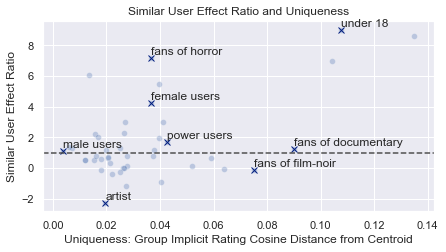

0.5497878450649337 0.00011080364766727074
0.55
0.18 0.24879520261886973
    implicit_cosine  num_ratings  like-boycott-ratio                  name
0          0.003839       753769            1.105260            male users
27         0.005867       130499            1.381721                 other
22         0.007190       395556            1.284915                 25-34
8          0.011929       268388            0.536670           fans of war
34         0.012163       105425            0.529750  executive/managerial
41         0.013496        49109            6.078358       sales/marketing
2          0.015235       283280            0.538811         fans of drama
23         0.015831       199003            2.237831                 35-44
12         0.015984       177567            0.763151         fans of crime
43         0.016867        46021            2.040764         self-employed
33         0.017846        37205           -0.101775    doctor/health care
13         0.017868       14

In [215]:
# Implicit Cosine vs. LB Ratio
sns.set(style="darkgrid")
sns.set_color_codes("dark")

fig, ax = plt.subplots(1,1, figsize=(7, 3.5))
filtered = df[df.num_ratings >= 20000]
print('len, std, mean', len(filtered.num_ratings), np.std(filtered.num_ratings), np.mean(filtered.num_ratings))
#filtered = df

y = 'like-boycott-ratio'

sns.scatterplot(
    x='implicit_cosine', y=y, data=filtered,
    ax=ax, 
    #marker=".", 
    #line_kws={'alpha':.3},
    alpha=0.3
)

def label_point(x, y, val, ax, names):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if str(point['val']) in names:
            ax.text(
                point['x'], point['y']+0.2, str(point['val']), 
            )
            ax.plot(point['x'], point['y'], 'bx')

label_point(
    filtered.implicit_cosine, filtered[y], filtered.name, plt.gca(),
    names=[
        'male users', 'female users', 'fans of film-noir', 'power users', 'under 18', 'artist',
        'fans of documentary', 'fans of horror',]
)  

plt.xlabel('Uniqueness: Group Implicit Rating Cosine Distance from Centroid')
plt.title('Similar User Effect Ratio and Uniqueness')
plt.ylabel('Similar User Effect Ratio')

ax.axhline(1, color='0.3', linestyle='--')
plt.savefig('implicitcosine_vs_lbratio.png', bbox_inches='tight', dpi=300)
plt.show()
pearson_val, pearson_p = pearsonr(filtered['implicit_cosine'], filtered[y])
print(pearson_val, pearson_p)
print(round(pearson_val, 2))
spearman_val, spearman_p = spearmanr(filtered['implicit_cosine'], filtered[y])
print(round(spearman_val, 2), spearman_p)

print(filtered[['implicit_cosine', 'num_ratings', y, 'name']].sort_values('implicit_cosine'))

In [216]:
names = {
    'name': 'Name', 'num_ratings': '# Ratings', 
    'like-boycott-ratio': 'Similar User Effect Ratio',
    'like-boycott-val':  '% change surfaced hits, similar users',
    'not-like-val':  '% change surfaced hits, other users',
}

table2_df = df[['name', 'num_ratings', 'like-boycott-val', 'not-like-val', 'like-boycott-ratio']].rename(index=str, columns=names)

table2_df.to_csv('table2.csv', index=False, float_format='%.2f', columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio'
])

print(table2_df)

                       Name  # Ratings  % change surfaced hits, similar users  \
0                male users     753769                              -0.709094   
1              female users     246440                              -0.378508   
2             fans of drama     283280                              -0.106945   
3         fans of animation     123314                              -0.140166   
4        fans of children's      85744                              -0.000587   
5           fans of musical     120386                              -0.126690   
6            fans of comedy     150470                              -0.007901   
7            fans of sci-fi     101277                              -0.156216   
8               fans of war     268388                              -0.123139   
9          fans of thriller     164050                              -0.034968   
10           fans of action     124499                              -0.059913   
11        fans of adventure 